# Simulated Galaxies: The Return

What we want in this notebook is to create and test several schemes to generate galaxy images. 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [25]:
import galsim
import tensorflow as tf
import tensorflow_datasets as tfds
import autometacal
import tqdm
from scipy.stats import truncnorm
import os

## Original

In [19]:
def make_data(Ngals=1,
  snr = 100,
  scale = 0.2,
  stamp_size = 51,
  psf_fwhm = 0.9,
  gal_hlr = 0.7,
  gal_g1 = [0],
  gal_g2 = [0], 
  flux=1.e5):
  """Simple exponetial profile toy model galaxy"""
  
  gal_list = []
  psf_list = []
 
  for n in range(Ngals):
    psf = galsim.Moffat(beta=2.5, 
                      fwhm=psf_fwhm)
    obj0 = galsim.Exponential(half_light_radius=gal_hlr,flux=flux).shear(g1=gal_g1[n],g2=gal_g2[n])
    obj = galsim.Convolve(psf, obj0)

    psf_image = psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array
    gal_image = obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale)
    noise = galsim.GaussianNoise()
    gal_image.addNoiseSNR(noise,snr=snr,preserve_flux=True)
    
    gal_image = tf.convert_to_tensor(gal_image.array)
    psf_image = tf.convert_to_tensor(psf_image)
    gal_list.append(gal_image)
    psf_list.append(psf_image)
  
  gal_image_stack = tf.stack(gal_list)
  psf_image_stack = tf.stack(psf_list)
  
  return gal_image_stack, psf_image_stack

get g1, g2:

In [20]:
gmax =.7 #max
gloc = 0 # mean
gsca = .3 #scatter
a, b = (-gmax - gloc) / gsca, (gmax - gloc) / gsca

g1=truncnorm.rvs(a, b, loc=gloc, scale=gsca,size=25)
g2=truncnorm.rvs(a, b, loc=gloc, scale=gsca,size=25)

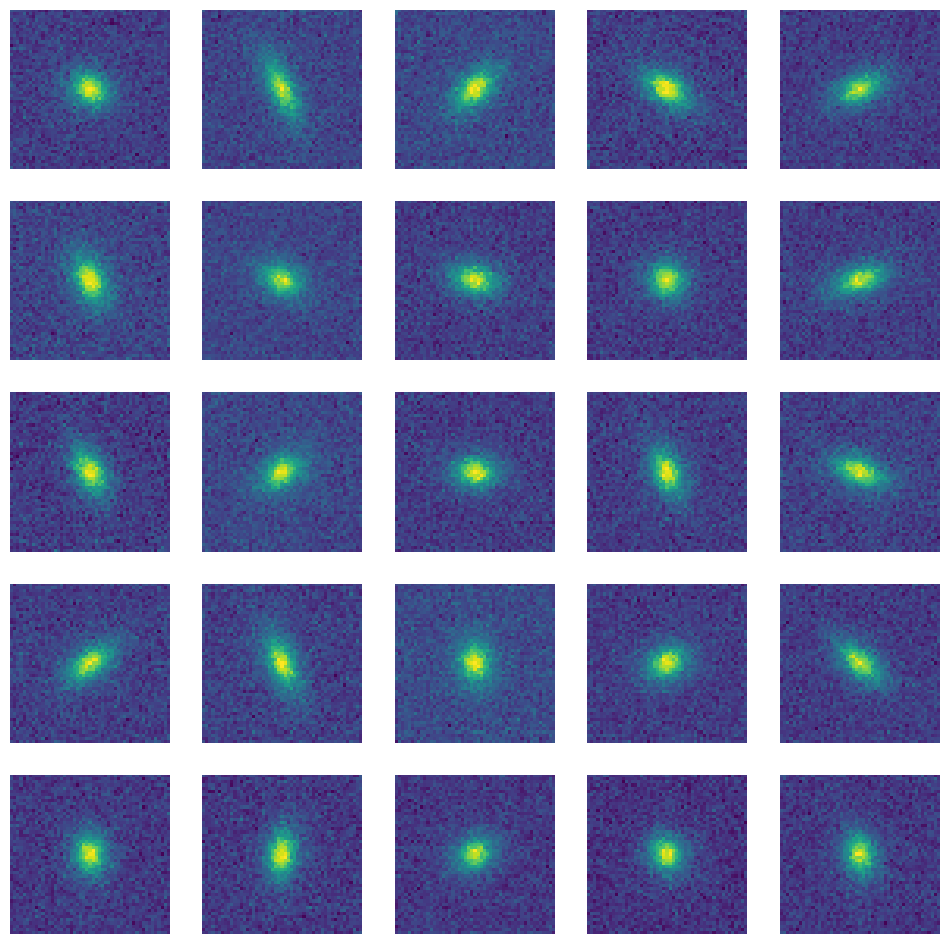

In [21]:
gal_images, _ = make_data(Ngals=25,scale=0.187,gal_g1=g1,gal_g2=g2)
style.use('default')
figure(figsize=(12,12))
for i in range(25):
  subplot(5,5,i+1)
  imshow(gal_images[i])
  axis('off')

## Parametric COSMOS

In [43]:
seed = 31415
gal_rng = galsim.BaseDeviate(seed)


In [74]:
def make_parametric_cosmos(ccat,j):
  """Creates CFIS-like images out of the parametric COSMOS galaxies."""
  #CFIS
  psf_fwhm = .65 # arcsec
  sky_level = 400 # ADU (~variance)
  pixel_scale = 0.187 # arcsec/pixel
  mag_zp = 32
  stamp_size=51
 
  #get magnitude & flux
  gal_mag = 23#ccat.param_cat[j][1]
  gal_flux = 10**(-(gal_mag-mag_zp)/2.5)

  psf = galsim.Kolmogorov(fwhm=psf_fwhm).withFlux(1.0)
  
  gal = ccat.makeGalaxy(index=j,gal_type='parametric').withFlux(gal_flux)

  obj = galsim.Convolve((psf, gal))
  img = obj.drawImage(nx=stamp_size, ny=stamp_size, scale=pixel_scale, method='fft')

  # Get snr
  S2 = np.sum(img.array**2)
  s2n = np.sqrt(S2/sky_level)

  noise = galsim.GaussianNoise(sigma=np.sqrt(sky_level), rng=gal_rng)
  img.addNoise(noise) # it updates directly the galsim object. It returns
                      # the variance if I remember well..

  #print(f"s2n: {s2n} (in galsim system)")
  return img.array, s2n, gal_mag

In [75]:
COSMOScat = galsim.COSMOSCatalog(dir = os.path.expanduser('~/Data/COSMOS_25.2_training_sample'),use_real=False)

<ipython-input-76-a9dfcc8ead3e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gal_images = array([make_parametric_cosmos(COSMOScat,j) for j in arange(25)])


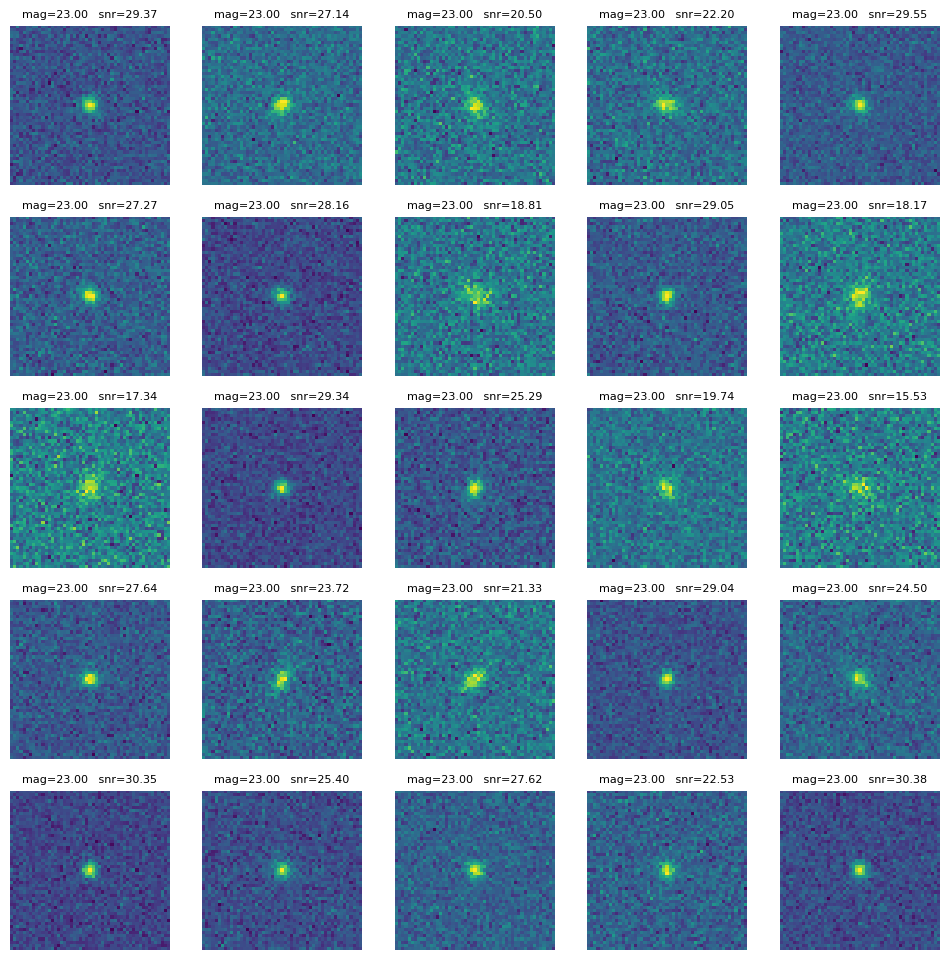

In [76]:
gal_images = array([make_parametric_cosmos(COSMOScat,j) for j in arange(25)])
style.use('default')
figure(figsize=(12,12))
for i in range(25):
  subplot(5,5,i+1)
  imshow(gal_images[i][0])
  title(f'mag={gal_images[i][2]:.2f}   snr={gal_images[i][1]:.2f}',fontsize=8)
  axis('off')

## Real Images - I 

In [81]:
COSMOScat = galsim.COSMOSCatalog(dir = os.path.expanduser('~/Data/COSMOS_25.2_training_sample'),use_real=True)

In [121]:
def make_cosmos_real(ccat,Ngals):
  """Just cutting stamps from the original gal image from HST"""
  gal_list = []
  psf_list = []
  n=0
  list_length = 0
  size=51

  while list_length < Ngals:
    gal=ccat.makeGalaxy(n)
        
    if (
      (min(gal.original_gal.image.array.shape) >= size) & 
      (min(gal.psf_image.array.shape) >= size) 
    ):
      centre_x_gal = gal.original_gal.image.array.shape[0]//2
      centre_y_gal = gal.original_gal.image.array.shape[1]//2
      
      centre_x_psf = gal.psf_image.array.shape[0]//2
      centre_y_psf = gal.psf_image.array.shape[1]//2
      
      psf_image = tf.convert_to_tensor(gal.psf_image.array[centre_x_psf - size //2 :
                                                           centre_x_psf + 1 + size //2 ,
                                                           centre_y_psf - size //2 :
                                                           centre_y_psf + 1 + size //2 ],
                                       dtype=tf.float32)
      gal_image = tf.convert_to_tensor(gal.gal_image.array[centre_x_gal - size //2 :
                                                           centre_x_gal + 1  + size //2,
                                                           centre_y_gal - size //2 :
                                                           centre_y_gal + 1 + size //2 ],
                                       dtype=tf.float32)
      gal_list.append(gal_image)
      psf_list.append(psf_image)
      list_length += 1
      
    else:
      print(min(gal.original_gal.image.array.shape),min(gal.psf_image.array.shape),end="\r")
    n += 1
    
      
  print()
  print(n)
  gal_image_stack = tf.stack(gal_list)
  psf_image_stack = tf.stack(psf_list)
  return gal_image_stack, psf_image_stack

In [122]:
gal_images, _ =make_cosmos_real(COSMOScat,25)

33 51
47


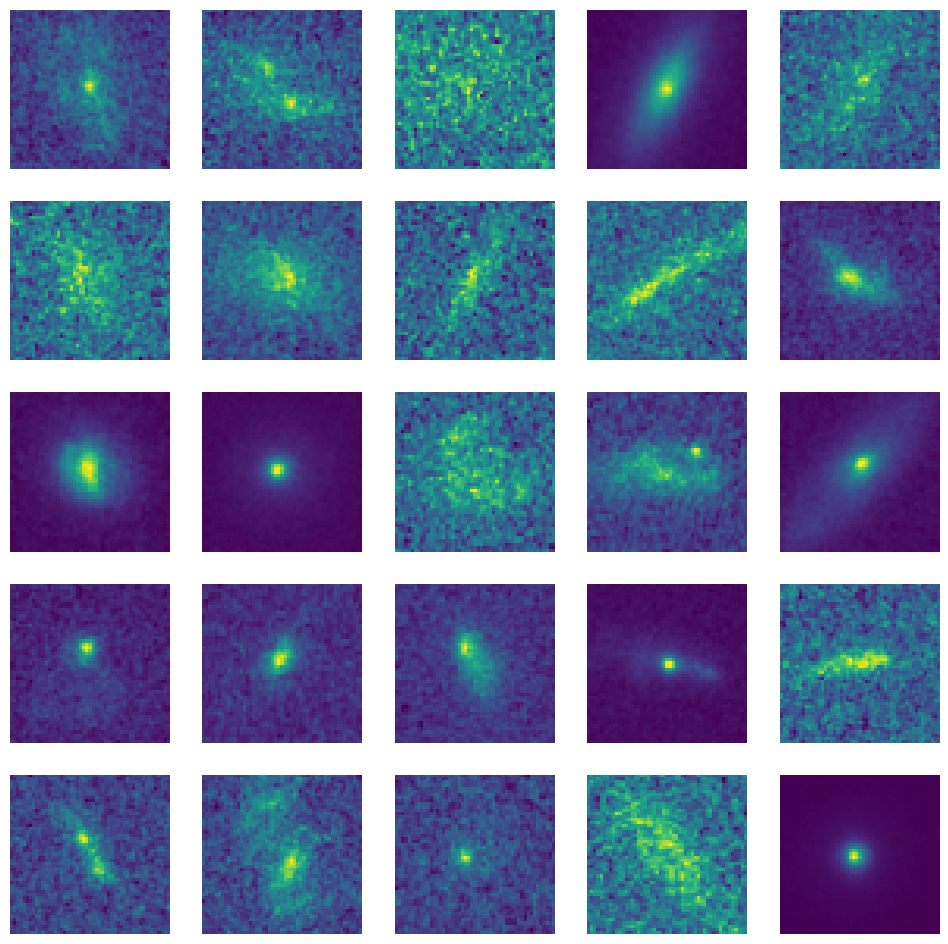

In [123]:
style.use('default')
figure(figsize=(12,12))
for i in range(25):
  subplot(5,5,i+1)
  imshow(gal_images[i])
  axis('off')

## Real Images II

In [150]:
ccat.makeGalaxy?

Signature:
ccat.makeGalaxy(
    index=None,
    gal_type=None,
    chromatic=False,
    noise_pad_size=5,
    deep=False,
    sersic_prec=0.05,
    rng=None,
    n_random=None,
    gsparams=None,
)
Docstring:
Routine to construct one or more `GSObject` instances corresponding to the catalog entry
with a particular index or indices.

The flux of the galaxy corresponds to a 1 second exposure time with the Hubble Space
Telescope.  Users who wish to simulate F814W images with a different telescope and an
exposure time longer than 1 second should multiply by that exposure time, and by the square
of the ratio of the effective diameter of their telescope compared to that of HST.
(Effective diameter may differ from the actual diameter if there is significant
obscuration.)  See demo11.py for an example that explicitly takes this normalization into
account.

Due to the adopted flux normalization, drawing into an image with the COSMOS bandpass,
zeropoint of 25.94, and pixel scale should give the 

In [147]:
def make_cosmos_real2(ccat,Ngals):
  """Convolve the real galaxies with a PSF"""
  gal_list = []
  psf_list = []
  n=0
  list_length = 0
  #CFIS
  psf_fwhm = .65 # arcsec
  sky_level = 0 # ADU (~variance)
  pixel_scale = 0.187 # arcsec/pixel
  mag_zp = 32
  size=51
 
  #get magnitude & flux
  gal_mag = 23#ccat.param_cat[j][1]
  gal_flux = 10**(-(gal_mag-mag_zp)/2.5)

  for n in range(Ngals):
    ccat = COSMOScat
    gal = ccat.makeGalaxy(index=n,gal_type='real')

    psf = galsim.Kolmogorov(fwhm=.6).withFlux(1.0)
    obs = galsim.Convolve([[gal,psf]])
    img = obs.drawImage(nx=size,ny=size)
    
    noise = galsim.GaussianNoise(sigma=np.sqrt(sky_level), rng=gal_rng)
    img.addNoise(noise)
    
    
    
    gal_list.append(img.array)
    psf_list.append(psf.drawImage(nx=51,ny=51).array)
  gal_image_stack = tf.stack(gal_list)
  psf_image_stack = tf.stack(psf_list)
  return gal_image_stack, psf_image_stack

In [148]:
gal_images, _ = make_cosmos_real2(COSMOScat,25)

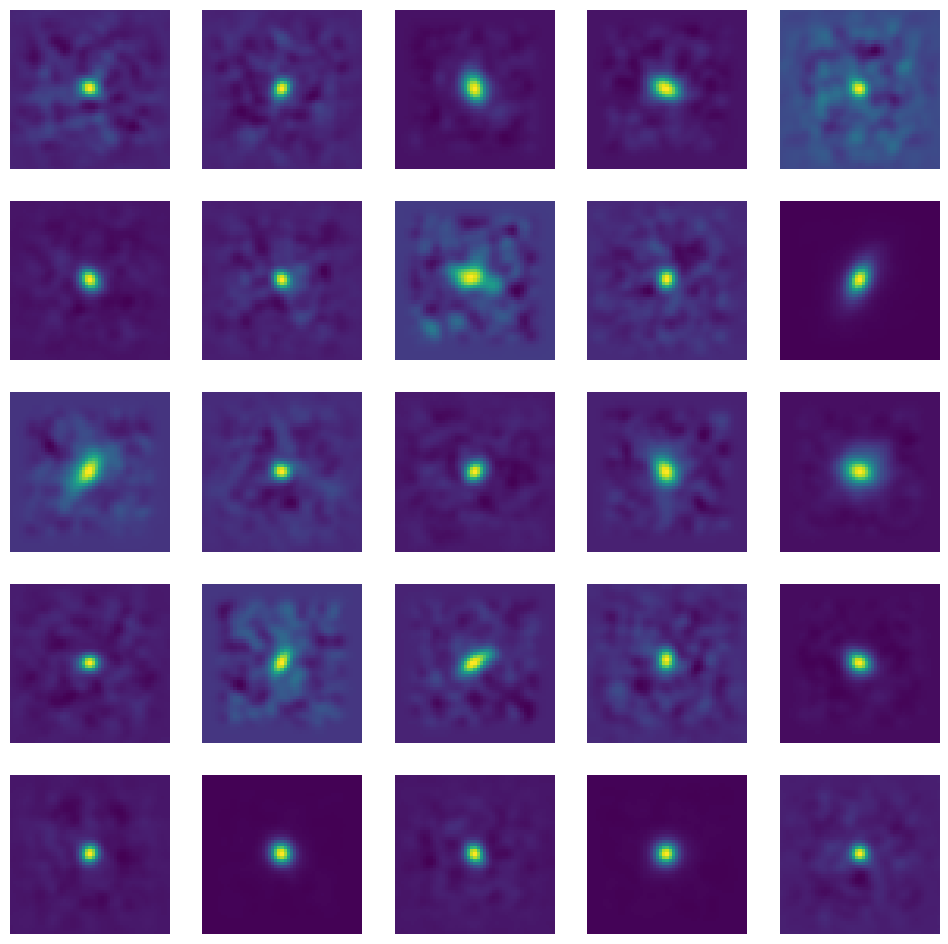

In [149]:
style.use('default')
figure(figsize=(12,12))
for i in range(25):
  subplot(5,5,i+1)
  imshow(gal_images[i])
  axis('off')